# Accessing the fly connectome dataset with CAVE

This tutorial provides a high-level overview for how to access FlyWire's dataset through CAVE. CAVE is the [connectome annotation versioning engine](https://www.biorxiv.org/content/10.1101/2023.07.26.550598v1.abstract), a service infrastructure for managing connectomics datasets and is hosted in the cloud for broad access. CAVE supports proofreading of datasets and their analysis even while proofreading is ongoing.

# CAVEclient and setup

The CAVEclient is a python library that facilitates communication with a CAVE system. It can be install with 

`pip install caveclient`

To install the caveclient when running this in a colab notebook, run:

In [1]:
!pip install caveclient
!pip install seaborn

and imported like so:

In [2]:
import caveclient
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## CAVE account setup

Each and every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. FlyWire's data is publicly available which means that no extra permissions need to be given to a new user account to access the data.

A Google account (or Google-enabled account) is required to create a CAVE account.

#### Start here if you do not have a CAVE account or are not sure

Login to CAVE to setup a new account. To do this go to this [website](https://prod.flywire-daf.com/materialize/views/datastack/flywire_fafb_public).

#### Once you have an account: Setup your token

Create a new token by running the next cell. Then, copy the token and insert it into the argument of the following cell. These two cells should be redone together to make sure that the correct token is stored on your machine. You can copy your token and store on as many machines as you like. If you think your token has been compromised just reset it but rerunning the following cell.

In [3]:
client = caveclient.CAVEclient()
client.auth.setup_token(make_new=True)

### Set or save your token

From the website that just opened up, paste your token here:

In [4]:
my_token = "your token goes here"

If you are running this on your local machine or on a server you can (optionally) store the token on your machine. This makes future uses easier.

In [5]:
# This might not work and that is okay
client.auth.save_token(token=my_token, overwrite=True)

## Initialize CAVEclient with a datastack

Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for FlyWire's public release is `flywire_fafb_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.

In [6]:
datastack_name = "flywire_fafb_public"
client = caveclient.CAVEclient(datastack_name)

# One can pass the token directly to the client:
# client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## Materialization versions

Data in CAVE is timestamped and periodically versioned - each (materialization) version corresponds to a specific timestamp. Individual versions are made publicly available. The materialization service provides annotation queries to the dataset. It is available under `client.materialize`. 

Currently the following versions are publicly available:

In [7]:
client.materialize.get_versions()

[630, 783]

And these are their associated timestamps (all timestamps are in UTC):

In [8]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 630: 2023-03-21 08:10:01.194185+00:00
Version 783: 2023-09-30 05:10:01.441140+00:00


The client will automatically query the latest materialization version. You can specify a `materialization_version` for every query if you want to access a specific version.

# Querying the dataset

Let's have a look what annotation tables are available:

In [9]:
client.materialize.get_tables()

['hierarchical_neuron_annotations',
 'neuron_information_v2',
 'synapses_nt_v1',
 'nuclei_v1',
 'proofread_neurons',
 'fly_synapses_neuropil_v6']

## Querying neurons

The `proofread_neurons` table contains all neurons that were released in a given version. The dataset contains many more segments that were either not proofread because they are small, or belong to non-neuronal cells or other structures such as trachea. Therefore, knowing the list of all segments that represent proofread neurons is useful. It can be queried in full:

In [10]:
proofread_neurons_df = client.materialize.query_table("proofread_neurons")
proofread_neurons_df

,id,created,superceded_id,valid,pt_supervoxel_id,pt_root_id,pt_position
0,32414,2023-06-19 06:44:57.863498+00:00,NaN,t,79871411195357919,720575940620919646,"[538210, 198330, 105601]"
1,1125,2023-06-19 06:43:33.633089+00:00,NaN,t,77195887289571552,720575940611775973,"[381459, 106763, 171723]"
2,32416,2023-06-19 06:44:57.865882+00:00,NaN,t,78955586729523534,720575940618135198,"[486480, 133840, 123110]"
3,32418,2023-06-19 06:44:57.867936+00:00,NaN,t,79589661206805006,720575940624783287,"[523906, 181893, 72760]"
4,32419,2023-06-19 06:44:57.869497+00:00,NaN,t,79589661207074646,720575940630755276,"[523523, 181919, 80829]"
...,...,...,...,...,...,...,...
139250,104828,2023-06-19 06:48:15.001237+00:00,NaN,t,83952592400822837,720575940626100238,"[776911, 183792, 174548]"
139251,104809,2023-06-19 06:48:14.983796+00:00,NaN,t,84798048190170122,720575940626915216,"[824625, 246096, 194229]"
139252,83362,2023-06-19 06:47:20.709997+00:00,NaN,t,75298954786869572,720575940645731620,"[272447, 288010, 156593]"
139253,104819,2023-06-19 06:48:14.992064+00:00,NaN,t,84658822530652061,720575940629075755,"[815896, 335911, 204215]"


In the table above each row is a proofread neuron. Segment IDs (aka neuron IDs) are called `root_ids` in CAVE. Each annotation is associated with at least one point with which data is associated; in this case `pt_root_id` and `pt_position` are the most relevant columns.

Positions in this table were calculated to be in the backbone of a neuron. This was found to be the most robust location to identify a neuron with as some do not have cell bodies and cell bodies are not central to fly neurons. There is a table that represents all _cell_ nuclei in the brain created by [Shang et al.](https://www.biorxiv.org/content/10.1101/2021.11.04.467197v1.abstract)

In [11]:
nuclei_df = client.materialize.query_table("nuclei_v1")
nuclei_df

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,7393349,2021-06-23 19:55:35.159040+00:00,NaN,t,26.141245,82827379285852979,720575940626838909,"[709888, 227744, 57160]","[708032, 226144, 54760]","[711904, 229440, 59280]"
1,7416439,2021-06-23 19:55:35.160196+00:00,NaN,t,11.523400,82827998029690530,720575940620043899,"[710592, 263392, 129800]","[708800, 262112, 128200]","[712064, 264832, 131080]"
2,7415038,2021-06-23 19:55:35.161401+00:00,NaN,t,32.895959,83038623024880664,720575940626046919,"[722528, 234656, 77000]","[720768, 232896, 74480]","[724224, 236576, 79360]"
3,7415013,2021-06-23 19:55:35.162579+00:00,NaN,t,53.711176,83038760463398837,720575940630311383,"[722912, 244032, 65200]","[720480, 242144, 62480]","[725600, 246208, 67760]"
4,7415848,2021-06-23 19:55:35.164060+00:00,NaN,t,9.280717,83038554439606237,720575940633370649,"[721984, 229792, 119560]","[720832, 228320, 118240]","[723232, 231264, 120840]"
...,...,...,...,...,...,...,...,...,...,...
143135,4389032,2021-06-23 20:02:31.089586+00:00,NaN,t,244.330332,79377386675948158,720575940629762043,"[511328, 113024, 48560]","[503744, 104128, 44600]","[520704, 122080, 53040]"
143136,8558952,2021-06-23 20:02:31.090874+00:00,NaN,t,253.359391,84870066067479558,720575940621362085,"[830720, 344608, 149840]","[821120, 335680, 146960]","[840576, 354912, 152880]"
143137,3076633,2021-06-23 20:02:31.092008+00:00,NaN,t,261.782528,78042030341189115,720575940650929273,"[433152, 210560, 223440]","[428544, 206976, 219120]","[437632, 214048, 227600]"
143138,3125634,2021-06-23 20:02:31.093103+00:00,NaN,t,274.994586,78113635431454405,720575940621426568,"[434208, 282112, 23400]","[429728, 278496, 19040]","[439264, 285568, 27320]"


Not all neurons contains have a cell body in the brain (e.g. sensory, ascending) and for ~6,000 of intrinsic neurons, the segmentation did not reach up to the cell bodies which are sitting at the outer layer of the brain. In those cases, the `pt_root_id` is 0. This table also contains glia cell bodies, as well as a few false positive annotations. 

Every table has an associated description which provides further context and references to publications. This feature is provided by the annotation service which can be reached at `cave.annotation`.

In [12]:
print(client.annotation.get_table_metadata("nuclei_v1")["description"])


FlyWire nucleus description
Nucleus version: 20210322

Nuclei in this table consist of center points (in nm), volume (in μm3), and bounding boxes (in nm).

The nucleus segmentation was generated by Shang Mu (smu@princeton.edu, Seung Lab at Princeton University) using a 2D convolutional neural network (CNN) and heuristic interpolations. The training data was assembled from annotations by Selden Koolman, Merlin Moore, Sarah Morejohn, Ben Silverman, Kyle Willie, Ryan Willie, Szi-chieh Yu and Shang Mu.

As this data was generated using a 2D, rather than 3D, neural network, defects are present in the detected nuclei, particularly where there are large defects in section alignment or a number of consecutive missing sections.

False positive fragments, nucleus fragments and partial nuclei are the most common type of defects. A simple, rudimentary method for cleaning up is to disregard small fragments by thresholding by segment size or by the z-dimension of the bounding boxes. A size threshol

Positions can be useful for analysis. The CAVEclient provides some convenience functions: 

Splitting of position columns into separate x, y, and z columns

In [13]:
nuclei_df = client.materialize.query_table("nuclei_v1", split_positions=True)
nuclei_df

,id,created,superceded_id,valid,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,7393349,2021-06-23 19:55:35.159040+00:00,NaN,t,26.141245,709888,227744,57160,708032,226144,54760,711904,229440,59280,82827379285852979,720575940626838909
1,7416439,2021-06-23 19:55:35.160196+00:00,NaN,t,11.523400,710592,263392,129800,708800,262112,128200,712064,264832,131080,82827998029690530,720575940620043899
2,7415038,2021-06-23 19:55:35.161401+00:00,NaN,t,32.895959,722528,234656,77000,720768,232896,74480,724224,236576,79360,83038623024880664,720575940626046919
3,7415013,2021-06-23 19:55:35.162579+00:00,NaN,t,53.711176,722912,244032,65200,720480,242144,62480,725600,246208,67760,83038760463398837,720575940630311383
4,7415848,2021-06-23 19:55:35.164060+00:00,NaN,t,9.280717,721984,229792,119560,720832,228320,118240,723232,231264,120840,83038554439606237,720575940633370649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143135,4389032,2021-06-23 20:02:31.089586+00:00,NaN,t,244.330332,511328,113024,48560,503744,104128,44600,520704,122080,53040,79377386675948158,720575940629762043
143136,8558952,2021-06-23 20:02:31.090874+00:00,NaN,t,253.359391,830720,344608,149840,821120,335680,146960,840576,354912,152880,84870066067479558,720575940621362085
143137,3076633,2021-06-23 20:02:31.092008+00:00,NaN,t,261.782528,433152,210560,223440,428544,206976,219120,437632,214048,227600,78042030341189115,720575940650929273
143138,3125634,2021-06-23 20:02:31.093103+00:00,NaN,t,274.994586,434208,282112,23400,429728,278496,19040,439264,285568,27320,78113635431454405,720575940621426568


Defining the position resolution. Resolutions are always in nanometers and this query asks for points to be provided in micrometers (aka 1000 nanometers):

In [14]:
nuclei_df = client.materialize.query_table("nuclei_v1", desired_resolution=[1000, 1000, 1000])
nuclei_df

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,7393349,2021-06-23 19:55:35.159040+00:00,NaN,t,26.141245,82827379285852979,720575940626838909,"[709.888, 227.744, 57.16]","[708.032, 226.144, 54.76]","[711.904, 229.44, 59.28]"
1,7416439,2021-06-23 19:55:35.160196+00:00,NaN,t,11.523400,82827998029690530,720575940620043899,"[710.592, 263.392, 129.8]","[708.8, 262.112, 128.2]","[712.064, 264.832, 131.08]"
2,7415038,2021-06-23 19:55:35.161401+00:00,NaN,t,32.895959,83038623024880664,720575940626046919,"[722.528, 234.656, 77.0]","[720.768, 232.896, 74.48]","[724.224, 236.576, 79.36]"
3,7415013,2021-06-23 19:55:35.162579+00:00,NaN,t,53.711176,83038760463398837,720575940630311383,"[722.912, 244.032, 65.2]","[720.48, 242.144, 62.48]","[725.6, 246.208, 67.76]"
4,7415848,2021-06-23 19:55:35.164060+00:00,NaN,t,9.280717,83038554439606237,720575940633370649,"[721.984, 229.792, 119.56]","[720.832, 228.32, 118.24]","[723.232, 231.264, 120.84]"
...,...,...,...,...,...,...,...,...,...,...
143135,4389032,2021-06-23 20:02:31.089586+00:00,NaN,t,244.330332,79377386675948158,720575940629762043,"[511.328, 113.024, 48.56]","[503.744, 104.128, 44.6]","[520.704, 122.08, 53.04]"
143136,8558952,2021-06-23 20:02:31.090874+00:00,NaN,t,253.359391,84870066067479558,720575940621362085,"[830.72, 344.608, 149.84]","[821.12, 335.68, 146.96]","[840.576, 354.912, 152.88]"
143137,3076633,2021-06-23 20:02:31.092008+00:00,NaN,t,261.782528,78042030341189115,720575940650929273,"[433.152, 210.56, 223.44]","[428.544, 206.976, 219.12]","[437.632, 214.048, 227.6]"
143138,3125634,2021-06-23 20:02:31.093103+00:00,NaN,t,274.994586,78113635431454405,720575940621426568,"[434.208, 282.112, 23.4]","[429.728, 278.496, 19.04]","[439.264, 285.568, 27.32]"


## Querying annotations - hierarchical annotations from Schlegel et al., 2023

[Schlegel et al](https://www.biorxiv.org/content/10.1101/2023.06.27.546055v2.abstract) introduced hierarchical annotations for all proofread neurons in the dataset. Figure 1 from their paper (shown below) outlines the hierarchy and renders individual groups of neuurons.



![](https://www.biorxiv.org/content/biorxiv/early/2023/07/15/2023.06.27.546055/F1.large.jpg)

To load all annotations (this will take ~20s):

In [15]:
hierarchical_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", limit=10)
hierarchical_annos_df

201 - "Limited query to 10 rows


,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,1,2023-06-19 06:43:32.562416+00:00,t,78253067652813181,720575940628857210,601615,2023-06-19 23:31:33.449997+00:00,t,1,super_class,central,"[443342, 203965, 157450]"
1,1,2023-06-19 06:43:32.562416+00:00,t,78253067652813181,720575940628857210,473637,2023-06-19 23:26:01.973320+00:00,t,1,flow,intrinsic,"[443342, 203965, 157450]"
2,2,2023-06-19 06:43:32.563301+00:00,t,82053323167374089,720575940626838909,879934,2023-09-30 05:09:51.441140+00:00,t,2,cell_type,CB0924,"[664417, 227538, 77011]"
3,2,2023-06-19 06:43:32.563301+00:00,t,82053323167374089,720575940626838909,601616,2023-06-19 23:31:33.451271+00:00,t,2,super_class,central,"[664417, 227538, 77011]"
4,2,2023-06-19 06:43:32.563301+00:00,t,82053323167374089,720575940626838909,473638,2023-06-19 23:26:01.974049+00:00,t,2,flow,intrinsic,"[664417, 227538, 77011]"
5,3,2023-06-19 06:43:32.564159+00:00,t,81842766824648491,720575940626046919,601617,2023-06-19 23:31:33.452516+00:00,t,3,super_class,central,"[653666, 259618, 110467]"
6,3,2023-06-19 06:43:32.564159+00:00,t,81842766824648491,720575940626046919,473639,2023-06-19 23:26:01.974760+00:00,t,3,flow,intrinsic,"[653666, 259618, 110467]"
7,4,2023-06-19 06:43:32.565063+00:00,t,82405647924682371,720575940630311383,601618,2023-06-19 23:31:33.453745+00:00,t,4,super_class,central,"[687457, 254763, 80194]"
8,4,2023-06-19 06:43:32.565063+00:00,t,82405647924682371,720575940630311383,473640,2023-06-19 23:26:01.975449+00:00,t,4,flow,intrinsic,"[687457, 254763, 80194]"
9,5,2023-06-19 06:43:32.566002+00:00,t,82756942157675987,720575940633370649,601619,2023-06-19 23:31:33.455445+00:00,t,5,super_class,visual_projection,"[707653, 222503, 145366]"


The `classification_system` column encodes the level of the hierarchy a given annotation belongs to. Only annotations for `flow` and `super class` are available for all neurons but finer annotations are only available for subsets of neurons. We can see that in the annotation counts for each hierarchy level:

## Subqueries - hierarchical annotations from Schlegel et al., 2023 continued

CAVE poses a limit on the size of a table that can be loaded at once. The current limit is `500,000` rows. This is to ensure the system is working for everyone and prevents accidentaly large queries to the server - that is particularly relevant for synapse queries. 

The hierarchical annotation table is too large to be loaded as a whole. To load a subset of the data, we can use a filter on any column to reduce the data footprint:

In [16]:
flow_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "flow"})
flow_annos_df

,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,135,2023-06-19 06:43:32.694340+00:00,t,78536398189730110,720575940628372613,760326,2023-09-30 05:09:51.441140+00:00,t,135,flow,efferent,"[462134, 314944, 202595]"
1,131206,2024-01-08 19:46:33.536372+00:00,t,79097217839414238,720575940620156283,760327,2023-09-30 05:09:51.441140+00:00,t,131206,flow,efferent,"[492890, 187909, 204117]"
2,138571,2024-01-08 19:46:56.609400+00:00,t,81277136946061019,720575940640372277,760328,2023-09-30 05:09:51.441140+00:00,t,138571,flow,intrinsic,"[620140, 99296, 158026]"
3,137463,2024-01-08 19:46:56.002999+00:00,t,80434498856324372,720575940634601954,760329,2023-09-30 05:09:51.441140+00:00,t,137463,flow,intrinsic,"[570818, 205376, 191260]"
4,133024,2024-01-08 19:46:44.939864+00:00,t,81840568002630413,720575940624155416,760330,2023-09-30 05:09:51.441140+00:00,t,133024,flow,intrinsic,"[652270, 128644, 169218]"
...,...,...,...,...,...,...,...,...,...,...,...,...
139250,104828,2023-06-19 06:48:15.001237+00:00,t,83952592400822837,720575940626100238,397994,2023-06-19 23:22:47.293270+00:00,t,104828,flow,intrinsic,"[776911, 183792, 174548]"
139251,104809,2023-06-19 06:48:14.983796+00:00,t,84798048190170122,720575940626915216,436766,2023-06-19 23:24:21.179830+00:00,t,104809,flow,intrinsic,"[824625, 246096, 194229]"
139252,83362,2023-06-19 06:47:20.709997+00:00,t,75298954786869572,720575940645731620,402701,2023-06-19 23:23:00.124836+00:00,t,83362,flow,intrinsic,"[272447, 288010, 156593]"
139253,104819,2023-06-19 06:48:14.992064+00:00,t,84658822530652061,720575940629075755,436758,2023-06-19 23:24:21.174050+00:00,t,104819,flow,intrinsic,"[815896, 335911, 204215]"


Besides `filter_equal_dict`, the CAVEclient provides `filter_in_dict` and `filter_out_dict` as options to restrict what data is loaded. Examples:

In [17]:
cell_class_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_class", "cell_type"]})
cell_class_type_annos_df

,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,30,2023-06-19 06:43:32.592246+00:00,t,79588355603633144,720575940614623455,784021,2023-09-30 05:09:51.441140+00:00,t,30,cell_class,pars_intercerebralis,"[521186, 102405, 87485]"
1,32,2023-06-19 06:43:32.594078+00:00,t,79588286884639566,720575940603765280,784022,2023-09-30 05:09:51.441140+00:00,t,32,cell_class,pars_intercerebralis,"[522523, 97588, 102599]"
2,106,2023-06-19 06:43:32.670532+00:00,t,79519361115064925,720575940616153371,784023,2023-09-30 05:09:51.441140+00:00,t,106,cell_class,pars_intercerebralis,"[518966, 183364, 54017]"
3,322,2023-06-19 06:43:32.918061+00:00,t,79309629405975492,720575940632879842,784024,2023-09-30 05:09:51.441140+00:00,t,322,cell_class,TPN,"[503664, 265302, 85460]"
4,116554,2023-06-19 06:48:44.982060+00:00,t,80574205418215064,720575940620926740,784025,2023-09-30 05:09:51.441140+00:00,t,116554,cell_class,pars_lateralis,"[578618, 142964, 148739]"
...,...,...,...,...,...,...,...,...,...,...,...,...
216657,83345,2023-06-19 06:47:20.696479+00:00,t,76071499211627283,720575940632125521,753717,2023-06-22 03:47:42.513711+00:00,t,83345,cell_type,T4a,"[316848, 199076, 184279]"
216658,83374,2023-06-19 06:47:20.719586+00:00,t,76071705369927669,720575940619054238,753718,2023-06-22 03:47:42.514694+00:00,t,83374,cell_type,T4a,"[317912, 208064, 180147]"
216659,104840,2023-06-19 06:48:15.014430+00:00,t,74595267680358869,720575940632299538,754848,2023-06-22 03:47:43.418885+00:00,t,104840,cell_type,Mi1,"[232864, 289213, 251319]"
216660,83326,2023-06-19 06:47:20.681260+00:00,t,84658616439355465,720575940623458428,753716,2023-06-22 03:47:42.513040+00:00,t,83326,cell_type,Mi1,"[818664, 323279, 224861]"


## Community annotations

The FlyWire community created additional annotations for ~85k cells in the dataset by the time of publication. These are free-form annotation tags that can be used for exploration and are not following any nomenclature.

In [18]:
community_anno_df = client.materialize.query_table("neuron_information_v2")

In [19]:
community_anno_df

,id,created,superceded_id,valid,tag,user_id,pt_supervoxel_id,pt_root_id,pt_position
0,1,2022-02-07 04:55:09.705964+00:00,NaN,t,putative fru,22,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
1,2,2022-02-07 04:55:09.709199+00:00,NaN,t,putative fru,2356,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
2,3,2022-02-07 04:55:09.711648+00:00,NaN,t,aIP1c,22,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
3,4,2022-02-07 04:55:09.714147+00:00,NaN,t,aIP1c,2356,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
4,5,2022-02-07 04:55:09.716362+00:00,NaN,t,putative fru,22,77197123904568079,720575940607848203,"[381456, 181024, 80800]"
...,...,...,...,...,...,...,...,...,...
156154,158470,2023-09-29 18:34:01.919332+00:00,NaN,t,protocerebral interneuron Delta7; PB interneur...,392,81278923786668088,720575940628493828,"[620616, 204680, 197880]"
156155,158471,2023-09-29 22:29:22.074318+00:00,NaN,t,Putative Translobula-plate 1; Tlp1 (with LOP a...,8,82546385882696610,720575940611942130,"[695628, 255712, 219440]"
156156,158472,2023-09-30 00:20:57.515962+00:00,NaN,t,Retinula axon; R7,96,84165210193334222,720575940630042011,"[788080, 276144, 101680]"
156157,158473,2023-09-30 00:24:42.774939+00:00,NaN,t,Retinula axon; R7,96,83602741276248008,720575940632709945,"[754976, 302952, 90120]"


## Synapse queries

### Details about FlyWire's synapses

FlyWire uses automatically annotated synapses that were produced by [Buhmann et al.](https://www.nature.com/articles/s41592-021-01183-7). Automation of synapse annotation is critical for circuit analysis but one should keep in mind that the classifier may contain biases that lead to better or worse results in different brain regions. For instance, this classifier was trained on data acquired from neuropils in the central brain and might perform worse in the optic lobe or for sensory neurons. In total, Buhmann et al. identified ~244 million _putative_ synapses.

### Details about removal of false positive synapses

Each synapse is a link from a pre- to a posynaptic site. As presynapses in the fly are usually polysynaptic, there are usually multiple synapses for each presynaptic site. They assigned a `connection_score` to every synapse which can be used to filter out false positives. Buhmann et al. suggest to correlate their predictions with those from [Heinrich et al.](https://link.springer.com/chapter/10.1007/978-3-030-00934-2_36) who segmented synaptic cleft on the same dataset. This is implemented through a `cleft_score` that is associated with each synapse. We found that filtering synapses with a `cleft_score > 50` works well for removing false positives without using the `connection_score`.

Additionally, some synapses were annotated multiple times. We implemented a distance based filtering to remove redundant synapses.

## Synapse assignment to neuropils

We assigned every synapse to a neuropil based on its presynaptic location. Synapses that were outside a neuropil were assigned to the closest neuropil if that was within 10 µm. 

### TLDR: Give me the data!

We created a filtered view of the synapse table that automatically applies all established filters to remove as many false positive synapses as possible. It also adds neuropil information. The view published with version 630 is `valid_synapses_nt_np`. For version 783 and later, we created `valid_synapses_nt_np_v6`, an updated version which only has minor differences to the previous version (`valid_synapses_nt_np` will remain functional for consistency). The main differences are that neuropil assignments in the optic lobes were improved. 

For technical reasons, a different function has to be called to query this view: 

In [20]:
client.materialize.query_view("valid_synapses_nt_np_v6", limit=10)

201 - "Limited query to 10 rows


,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,6,720575940630786105,720575940610739662,389.255432,79,0.011380,0.786194,0.003691,0.004627,0.001929,0.192179,t,76916748439646533,76916748439640439,AVLP_L,"[366592, 246144, 74360]","[366584, 246216, 74320]"
1,11,720575940630786105,720575940545913232,469.296295,147,0.004232,0.967565,0.000087,0.000342,0.000182,0.027592,t,76916748439639250,76916748439645298,AVLP_L,"[366560, 246144, 74440]","[366508, 246232, 74440]"
2,14,720575940630786105,720575940545912208,431.531738,130,0.000786,0.993792,0.000002,0.000006,0.000004,0.005412,t,76916748439651358,76916748439646534,AVLP_L,"[366428, 246060, 74560]","[366356, 246136, 74520]"
3,15,720575940630906435,720575940627911895,475.069672,140,0.376253,0.278226,0.332757,0.001309,0.000762,0.010693,t,76916748439657631,76916748439647565,AVLP_L,"[365584, 245064, 74680]","[365672, 245036, 74640]"
4,16,720575940630906435,720575940545916816,407.200562,151,0.341289,0.149622,0.499909,0.001995,0.001269,0.005916,t,76916748439651251,76916748439648883,AVLP_L,"[365624, 245136, 74680]","[365712, 245200, 74720]"
5,18,720575940630786105,720575940545920912,217.466217,122,0.007093,0.939359,0.001130,0.000747,0.000196,0.051474,t,76916748439663007,76916748439651348,AVLP_L,"[366252, 245948, 74640]","[366168, 245976, 74640]"
6,21,720575940630786105,720575940624184764,56.978813,146,0.006275,0.971317,0.000977,0.000983,0.000085,0.020363,t,76916748439651358,76916748439650144,AVLP_L,"[366232, 246012, 74680]","[366136, 246084, 74640]"
7,22,720575940630906435,720575940545901968,478.272552,146,0.334301,0.341355,0.311997,0.007425,0.000349,0.004572,t,76916748439651251,76916748439653785,AVLP_L,"[365624, 245112, 74720]","[365732, 245096, 74720]"
8,26,720575940619149904,720575940627911895,58.005123,145,0.310759,0.131895,0.522028,0.017178,0.004899,0.013241,t,76916748439651360,76916748439648983,AVLP_L,"[365704, 246068, 74720]","[365656, 245948, 74720]"
9,27,720575940619149904,720575940545911952,17.302750,143,0.262804,0.049032,0.643314,0.018544,0.008741,0.017565,t,76916748439651360,76916748439651344,AVLP_L,"[365756, 246080, 74720]","[365800, 245980, 74720]"


This query limits the query to 10 randomly chosen rows. The maximum per query is 500,000. There are approximately 110 million synapses available in this view. Queries need to be resticted to a given set of neurons.

### Querying synapses for specific neurons

Let's query synapses for this AMMC-A1:
https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5319936417202176

In [21]:
root_id = 720575940631693610

presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

In [22]:
presyn_df

,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,117830668,720575940631693610,720575940620443162,370.392456,60,0.047310,0.718833,0.130120,0.015852,0.007914,0.079971,t,81560742159585205,81560742159589162,PLP_R,"[634620, 226424, 141680]","[634608, 226444, 141720]"
1,75679622,720575940631693610,720575940635047672,139.755951,142,0.032243,0.883559,0.036865,0.009253,0.005225,0.032856,t,81420279548633717,81420279548622891,PVLP_R,"[628280, 243384, 125360]","[628188, 243296, 125360]"
2,10626687,720575940631693610,720575940623646963,72.089195,149,0.018603,0.923716,0.005724,0.001676,0.002917,0.047364,t,81702166708387316,81702166708369049,AVLP_R,"[643152, 267728, 97200]","[643112, 267824, 97240]"
3,10626689,720575940631693610,720575940621104628,131.851089,141,0.010995,0.971356,0.000803,0.000471,0.001374,0.015000,t,81702166708387316,81702166708384466,AVLP_R,"[643104, 267720, 97280]","[643144, 267800, 97320]"
4,10293850,720575940631693610,720575940624425344,185.360291,126,0.087320,0.796282,0.013954,0.007258,0.025200,0.069985,t,81632004122605454,81632004122600098,AVLP_R,"[638932, 279244, 96280]","[638836, 279144, 96240]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,151947837,720575940631693610,720575940621547689,8.619675,140,0.048986,0.500239,0.012006,0.017138,0.400640,0.020991,t,81491541511938809,81491541511940403,AMMC_R,"[634416, 295480, 89520]","[634512, 295492, 89520]"
384,126950546,720575940631693610,720575940632499757,102.689369,71,0.125350,0.505188,0.085491,0.002560,0.071755,0.209656,t,81491197914884088,81491197914895913,SAD,"[631112, 275452, 100200]","[631228, 275412, 100160]"
385,218790405,720575940631693610,720575940611602552,6.678510,92,0.044414,0.142395,0.312924,0.001593,0.251710,0.246964,t,81560879531460479,81560879531454661,PVLP_R,"[635924, 232912, 121880]","[635960, 232988, 121880]"
386,218047340,720575940631693610,720575940628579066,30.840708,142,0.032452,0.721918,0.149166,0.031120,0.007521,0.057823,t,81349773298958087,81349773298949222,AVLP_R,"[625480, 235308, 122640]","[625472, 235412, 122640]"


In [23]:
postsyn_df

,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,128738026,720575940639232309,720575940631693610,166.925522,140,0.293312,0.706687,3.033506e-08,7.517577e-10,8.469752e-09,6.843862e-07,t,81632485225862123,81632485225856040,SAD,"[642020, 307040, 110920]","[641824, 307016, 110920]"
1,105342698,720575940639232309,720575940631693610,296.410767,65,0.870307,0.108823,8.390854e-03,3.947024e-05,7.658201e-04,1.167465e-02,t,81561635445229950,81561635445221449,AMMC_R,"[637820, 280568, 107320]","[637960, 280444, 107280]"
2,824004,720575940625887119,720575940631693610,18.143377,87,0.000350,0.047908,3.154862e-04,1.214293e-05,9.513536e-01,6.087947e-05,t,81561978908660621,81561978908674707,AMMC_R,"[638592, 299008, 74440]","[638576, 299132, 74440]"
3,352072,720575940613380914,720575940631693610,378.164032,143,0.026012,0.919231,8.127017e-04,1.418136e-05,1.580350e-02,3.812663e-02,t,81491472725507849,81491472725512561,AMMC_R,"[632944, 292452, 74200]","[632848, 292488, 74160]"
4,352078,720575940613380914,720575940631693610,56.065281,130,0.005345,0.981488,3.448543e-05,4.510183e-07,8.544329e-03,4.587861e-03,t,81491472725513991,81491472725512561,AMMC_R,"[633000, 292556, 74320]","[632956, 292672, 74320]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,129449505,720575940631624785,720575940631693610,334.592163,139,0.025598,0.849592,1.021429e-02,5.777769e-04,1.153867e-02,1.024786e-01,t,81490854384391854,81490854384366188,PVLP_R,"[631952, 253672, 112400]","[631864, 253828, 112400]"
1918,91118513,720575940626404337,720575940631693610,530.672913,124,0.004727,0.957765,1.230918e-02,8.542001e-03,1.444312e-04,1.651207e-02,t,81138804571932051,81138804571933468,SPS_R,"[610936, 242004, 126720]","[610832, 242064, 126720]"
1919,235515151,720575940612612094,720575940631693610,78.667389,158,0.049604,0.184570,7.333407e-01,8.835521e-03,4.156235e-03,1.949376e-02,t,81138667066289445,81138667066307148,PVLP_R,"[613988, 235216, 119680]","[614064, 235148, 119720]"
1920,10093480,720575940625738073,720575940631693610,25.832794,149,0.033539,0.704020,5.440734e-02,3.434047e-03,4.135636e-02,1.632432e-01,t,81772535452571229,81772535452576339,AVLP_R,"[648748, 266056, 97240]","[648704, 266164, 97280]"


## Example Analysis: Super class distribution of partners

For a single neuron, we want to analyze the distribution of pre- and postsynaptic partner types (here: super classes).

First, we load the super classes from the hierarchical annotation table and simplify the table:

In [24]:
super_class_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "super_class"})
unique_super_class = super_class_annos_df["cell_type"].unique()

super_class_annos_df

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,pt_position
0,771969,2023-09-30 05:09:51.441140+00:00,t,135,super_class,motor,135,2023-06-19 06:43:32.694340+00:00,t,78536398189730110,720575940628372613,"[462134, 314944, 202595]"
1,771970,2023-09-30 05:09:51.441140+00:00,t,131206,super_class,descending,131206,2024-01-08 19:46:33.536372+00:00,t,79097217839414238,720575940620156283,"[492890, 187909, 204117]"
2,771971,2023-09-30 05:09:51.441140+00:00,t,138571,super_class,central,138571,2024-01-08 19:46:56.609400+00:00,t,81277136946061019,720575940640372277,"[620140, 99296, 158026]"
3,771972,2023-09-30 05:09:51.441140+00:00,t,137463,super_class,central,137463,2024-01-08 19:46:56.002999+00:00,t,80434498856324372,720575940634601954,"[570818, 205376, 191260]"
4,771973,2023-09-30 05:09:51.441140+00:00,t,133024,super_class,central,133024,2024-01-08 19:46:44.939864+00:00,t,81840568002630413,720575940624155416,"[652270, 128644, 169218]"
...,...,...,...,...,...,...,...,...,...,...,...,...
139250,525972,2023-06-19 23:28:18.685794+00:00,t,104828,super_class,optic,104828,2023-06-19 06:48:15.001237+00:00,t,83952592400822837,720575940626100238,"[776911, 183792, 174548]"
139251,564744,2023-06-19 23:29:51.384628+00:00,t,104809,super_class,optic,104809,2023-06-19 06:48:14.983796+00:00,t,84798048190170122,720575940626915216,"[824625, 246096, 194229]"
139252,530679,2023-06-19 23:28:31.069595+00:00,t,83362,super_class,optic,83362,2023-06-19 06:47:20.709997+00:00,t,75298954786869572,720575940645731620,"[272447, 288010, 156593]"
139253,564736,2023-06-19 23:29:51.379168+00:00,t,104819,super_class,optic,104819,2023-06-19 06:48:14.992064+00:00,t,84658822530652061,720575940629075755,"[815896, 335911, 204215]"


In [25]:
pre_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_super_class"})
post_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_super_class"})

Next, we load the synapses for a specific neuron (this could also be a set of neurons):

In [26]:
root_id = 720575940631693610

presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

Merging the synapse and the annotation tables:

In [27]:
post_syn_super_df = pd.merge(postsyn_df, pre_super_class_annos_df, on="pre_pt_root_id")
pre_syn_super_df = pd.merge(presyn_df, post_super_class_annos_df, on="post_pt_root_id")

And finally plotting the distribution of synapses by partner super class

<Axes: xlabel='pre_super_class', ylabel='count'>

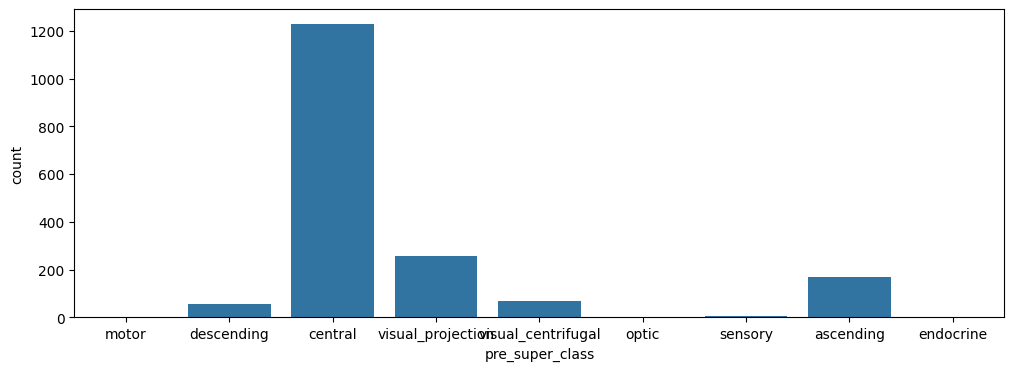

In [28]:
plt.subplots(figsize=(12, 4))
sns.countplot(post_syn_super_df, x="pre_super_class", order=unique_super_class)

<Axes: xlabel='post_super_class', ylabel='count'>

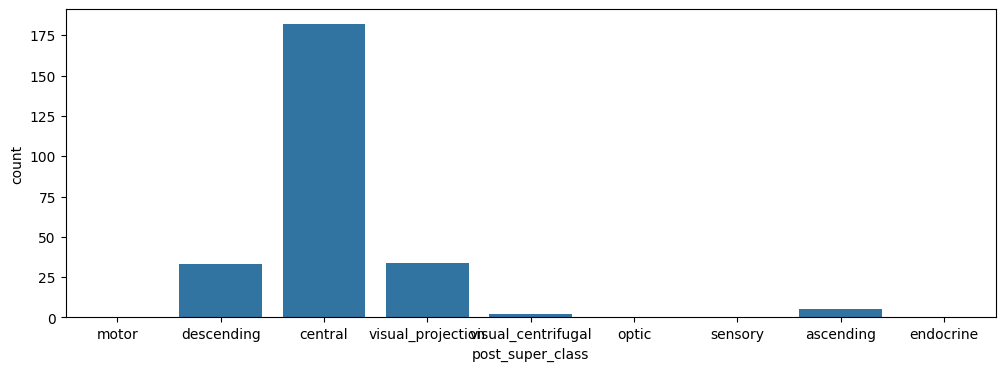

In [29]:
plt.subplots(figsize=(12, 4))
sns.countplot(pre_syn_super_df, x="post_super_class", order=unique_super_class)